AI 期末作業 - 自動化標籤生成與 DNN 週間/週末分類
-------------
流程：
1. 資料讀取與熱點篩選
2. K-Means 聚類：將 75 天分為兩類，並利用規則自動定義平日/週末
3. 視覺化驗證：繪製 75 天的分類條碼圖 (Barcode Plot)
4. DNN 模型建置與訓練：學習區分平日與週末的人流模式

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 設定隨機種子以確保結果可重現
torch.manual_seed(42)
np.random.seed(42)

第一部分：資料準備與 K-Means 自動標籤

In [2]:
print("--- [Phase 1] 開始進行 K-Means 自動標籤生成 ---")

# 1. 讀取資料
data_path = "../data/task1_dataset_kotae.csv" 
try:
    df = pd.read_csv(data_path)
    print(f"成功讀取資料，共 {len(df)} 筆")
except FileNotFoundError:
    print(f"錯誤：找不到檔案 {data_path}，請確認路徑。")
    exit()


--- [Phase 1] 開始進行 K-Means 自動標籤生成 ---
成功讀取資料，共 111535175 筆


In [3]:

# 2. 篩選熱點網格 (以 x=135, y=77 為例)
# 選定一個高流量網格作為該城市的代表，用來判斷日期屬性
target_x, target_y = 135, 77
print(f"鎖定分析網格: x={target_x}, y={target_y}")
df_grid = df[(df['x'] == target_x) & (df['y'] == target_y)].copy()


鎖定分析網格: x=135, y=77


In [4]:

# 3. 轉換資料格式: (天數, 時間點)
# 我們需要每一天完整的 48 個時間點數據作為特徵
grid_counts = df_grid.groupby(['d', 't']).size().reset_index(name='count')
day_profile = grid_counts.pivot(index='d', columns='t', values='count').fillna(0)


In [5]:

# 確保 0~74 天與 0~47 時間點都存在
day_profile = day_profile.reindex(index=np.arange(75), fill_value=0)
day_profile = day_profile.reindex(columns=np.arange(48), fill_value=0)

X_days = day_profile.values  # Shape: (75, 48)


In [6]:

# 4. 執行 K-Means 分群 (k=2)
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_days)


In [7]:

# 5. 自動判斷哪一群是 "週末"
# 邏輯：檢查兩群在「早上通勤時段 (t=14~18, 約 7:00-9:00)」的平均流量
# 平日早上的流量通常顯著高於週末
morning_peak_cols = [14, 15, 16, 17, 18]
cluster_0_avg = X_days[clusters == 0][:, morning_peak_cols].mean()
cluster_1_avg = X_days[clusters == 1][:, morning_peak_cols].mean()

print(f"Cluster 0 早晨平均人流: {cluster_0_avg:.2f}")
print(f"Cluster 1 早晨平均人流: {cluster_1_avg:.2f}")

if cluster_0_avg > cluster_1_avg:
    # Cluster 0 是平日(流量大), Cluster 1 是週末
    weekday_label = 0
    weekend_label = 1
    print("=> 判定 Cluster 0 為平日, Cluster 1 為週末")
else:
    # Cluster 1 是平日, Cluster 0 是週末
    weekday_label = 1
    weekend_label = 0
    print("=> 判定 Cluster 1 為平日, Cluster 0 為週末")

# 建立最終標籤 (0: 平日, 1: 週末)
# 這裡我們將 K-Means 的結果轉換成語意明確的標籤
final_labels = np.zeros(75)
final_labels[clusters == weekend_label] = 1  # 週末設為 1
final_labels[clusters == weekday_label] = 0  # 平日設為 0


Cluster 0 早晨平均人流: 67.51
Cluster 1 早晨平均人流: 190.87
=> 判定 Cluster 1 為平日, Cluster 0 為週末


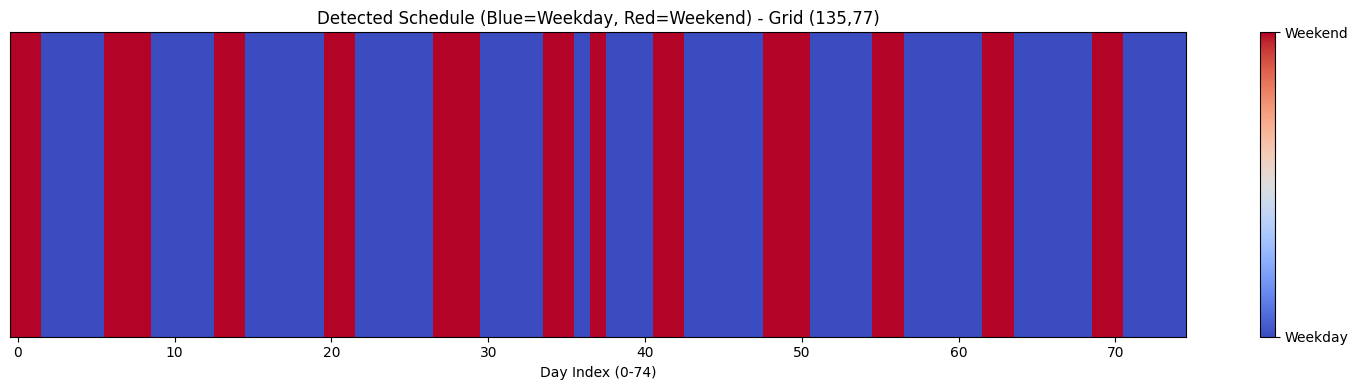

標籤生成完畢: 平日 49 天, 週末 26 天


In [8]:

# 6. 視覺化 K-Means 結果 (條碼圖)
# 這是驗證 7 天週期性最重要的步驟
plt.figure(figsize=(15, 4))
plt.imshow([final_labels], aspect='auto', cmap='coolwarm', interpolation='nearest')
plt.title(f'Detected Schedule (Blue=Weekday, Red=Weekend) - Grid ({target_x},{target_y})')
plt.xlabel('Day Index (0-74)')
plt.yticks([])
cbar = plt.colorbar(ticks=[0, 1])
cbar.ax.set_yticklabels(['Weekday', 'Weekend'])
plt.tight_layout()
plt.show()

# 輸出統計
n_weekdays = np.sum(final_labels == 0)
n_weekends = np.sum(final_labels == 1)
print(f"標籤生成完畢: 平日 {n_weekdays} 天, 週末 {n_weekends} 天")

第二部分：DNN 模型訓練

In [9]:
print("\n--- [Phase 2] 開始建立與訓練 DNN 模型 ---")

# 1. 資料正規化 (Normalization)
# 神經網路對數值範圍敏感，使用 MinMaxScaler 將人數縮放到 0-1 之間
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_days)



--- [Phase 2] 開始建立與訓練 DNN 模型 ---


In [10]:

# 2. 分割訓練集與測試集
# 輸入: 每天 48 個時間點的人流向量 (Batch, 48)
# 輸出: 是平日還是週末 (Batch, 2)
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_scaled, final_labels, test_size=0.2, random_state=42, stratify=final_labels
)

# 轉為 Tensor
X_train = torch.FloatTensor(X_train_np)
X_test = torch.FloatTensor(X_test_np)
y_train = torch.LongTensor(y_train_np)
y_test = torch.LongTensor(y_test_np)

print(f"訓練集形狀: {X_train.shape}")
print(f"測試集形狀: {X_test.shape}")


訓練集形狀: torch.Size([60, 48])
測試集形狀: torch.Size([15, 48])


In [11]:

# 3. 定義 DNN 模型架構
class DayTypeClassifier(nn.Module):
    def __init__(self, input_dim=48, hidden_dim=64):
        super(DayTypeClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),  # 加入 BN 加速收斂
            nn.Dropout(0.3),             # 加入 Dropout 防止過擬合
            
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(32, 2)             # 輸出 2 類 (平日/週末)
        )
        
    def forward(self, x):
        return self.model(x)

model = DayTypeClassifier()
print(model)


DayTypeClassifier(
  (model): Sequential(
    (0): Linear(in_features=48, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=32, out_features=2, bias=True)
  )
)


In [12]:

# 4. 設定訓練參數
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
epochs = 100


In [13]:

# 5. 訓練迴圈
history = {'loss': [], 'acc': [], 'val_loss': [], 'val_acc': []}

print("開始訓練...")
for epoch in range(epochs):
    # Train
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    # 計算訓練準確率
    _, preds = torch.max(outputs, 1)
    train_acc = (preds == y_train).float().mean()
    
    # Eval
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)
        _, val_preds = torch.max(val_outputs, 1)
        val_acc = (val_preds == y_test).float().mean()
    
    # 紀錄
    history['loss'].append(loss.item())
    history['acc'].append(train_acc.item())
    history['val_loss'].append(val_loss.item())
    history['val_acc'].append(val_acc.item())
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Loss: {loss.item():.4f} | Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")


開始訓練...
Epoch 10/100 | Loss: 0.0466 | Acc: 1.0000 | Val Acc: 0.9333
Epoch 20/100 | Loss: 0.0015 | Acc: 1.0000 | Val Acc: 1.0000
Epoch 30/100 | Loss: 0.0001 | Acc: 1.0000 | Val Acc: 1.0000
Epoch 40/100 | Loss: 0.0000 | Acc: 1.0000 | Val Acc: 1.0000
Epoch 50/100 | Loss: 0.0000 | Acc: 1.0000 | Val Acc: 1.0000
Epoch 60/100 | Loss: 0.0001 | Acc: 1.0000 | Val Acc: 1.0000
Epoch 70/100 | Loss: 0.0000 | Acc: 1.0000 | Val Acc: 1.0000
Epoch 80/100 | Loss: 0.0001 | Acc: 1.0000 | Val Acc: 1.0000
Epoch 90/100 | Loss: 0.0001 | Acc: 1.0000 | Val Acc: 1.0000
Epoch 100/100 | Loss: 0.0000 | Acc: 1.0000 | Val Acc: 1.0000


第三部分：結果評估與視覺化


--- [Phase 3] 訓練結果評估 ---


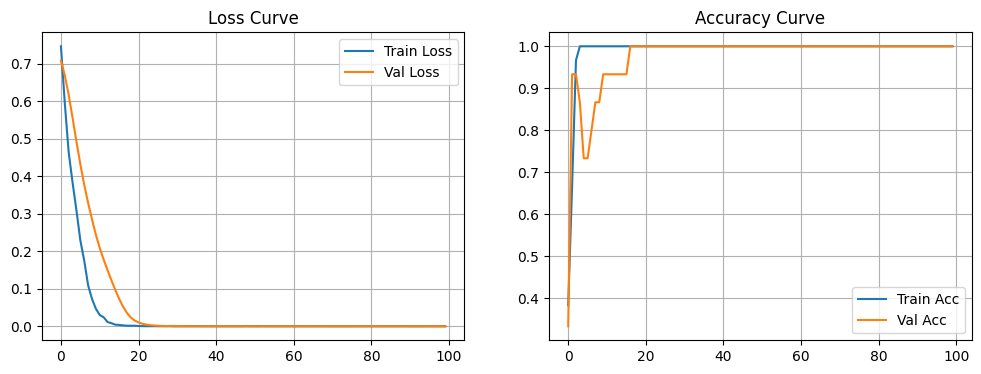

In [14]:
print("\n--- [Phase 3] 訓練結果評估 ---")

# 1. 繪製 Loss 與 Accuracy 曲線
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history['loss'], label='Train Loss')
ax1.plot(history['val_loss'], label='Val Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

ax2.plot(history['acc'], label='Train Acc')
ax2.plot(history['val_acc'], label='Val Acc')
ax2.set_title('Accuracy Curve')
ax2.legend()
ax2.grid(True)

plt.show()


In [15]:

# 2. 混淆矩陣 (Confusion Matrix)
model.eval()
with torch.no_grad():
    y_pred_logits = model(X_test)
    _, y_pred = torch.max(y_pred_logits, 1)

cm = confusion_matrix(y_test, y_pred)
print("\n混淆矩陣:")
print(cm)
print("\n分類報告:")
print(classification_report(y_test, y_pred, target_names=['Weekday', 'Weekend']))



混淆矩陣:
[[10  0]
 [ 0  5]]

分類報告:
              precision    recall  f1-score   support

     Weekday       1.00      1.00      1.00        10
     Weekend       1.00      1.00      1.00         5

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



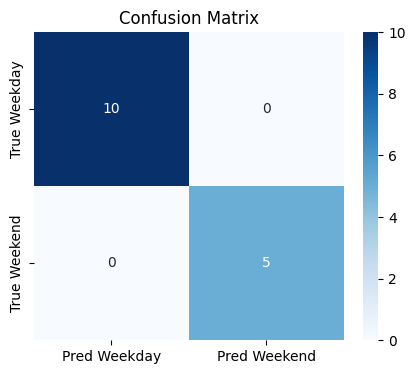

作業腳本執行完畢。


In [16]:

# 3. 繪製混淆矩陣圖
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred Weekday', 'Pred Weekend'],
            yticklabels=['True Weekday', 'True Weekend'])
plt.title('Confusion Matrix')
plt.show()

print("作業腳本執行完畢。")